<a href="https://colab.research.google.com/github/Thiraput01/My_ML_learning/blob/main/LSTM/Amazon_Stock_Forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from copy import deepcopy as dc
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
data = pd.read_csv('AMZN.csv')
data

,Date,Open,High,Low,Close,Adj Close,Volume
0,1997-05-15,0.121875,0.125000,0.096354,0.097917,0.097917,1443120000
1,1997-05-16,0.098438,0.098958,0.085417,0.086458,0.086458,294000000
2,1997-05-19,0.088021,0.088542,0.081250,0.085417,0.085417,122136000
3,1997-05-20,0.086458,0.087500,0.081771,0.081771,0.081771,109344000
4,1997-05-21,0.081771,0.082292,0.068750,0.071354,0.071354,377064000
...,...,...,...,...,...,...,...
6511,2023-03-30,101.550003,103.040001,101.010002,102.000000,102.000000,53633400
6512,2023-03-31,102.160004,103.489998,101.949997,103.290001,103.290001,56704300
6513,2023-04-03,102.300003,103.290001,101.430000,102.410004,102.410004,41135700
6514,2023-04-04,102.750000,104.199997,102.110001,103.949997,103.949997,48662500


In [ ]:
data = data[['Date', 'Close']]
data

,Date,Close
0,1997-05-15,0.097917
1,1997-05-16,0.086458
2,1997-05-19,0.085417
3,1997-05-20,0.081771
4,1997-05-21,0.071354
...,...,...
6511,2023-03-30,102.000000
6512,2023-03-31,103.290001
6513,2023-04-03,102.410004
6514,2023-04-04,103.949997


In [ ]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cpu'

<ipython-input-7-eef3cfff9d19>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = pd.to_datetime(data['Date'])


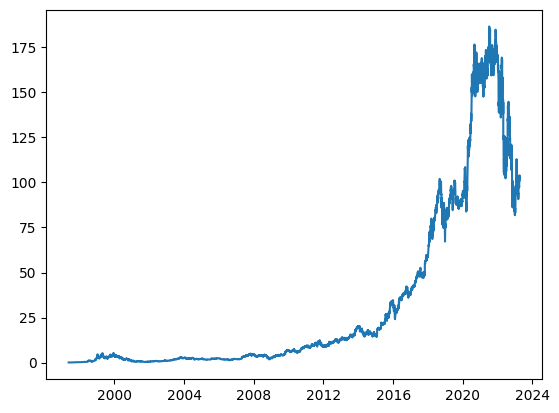

In [ ]:
data['Date'] = pd.to_datetime(data['Date'])
plt.plot(data['Date'], data['Close'])

In [ ]:
def prep_for_lstm(df, n_steps):
  df = dc(df)
  df['Date'] = pd.to_datetime(df['Date'])
  df.set_index('Date', inplace=True)

  for i in range(1, n_steps+1):
    df[f'Close(t-{i})'] = df['Close'].shift(i)

  df.dropna(inplace=True)

  return df

look_back = 7
shifted_data = prep_for_lstm(data, look_back)
shifted_data

,Close,Close(t-1),Close(t-2),Close(t-3),Close(t-4),Close(t-5),Close(t-6),Close(t-7)
Date,,,,,,,,
1997-05-27,0.079167,0.075000,0.069792,0.071354,0.081771,0.085417,0.086458,0.097917
1997-05-28,0.076563,0.079167,0.075000,0.069792,0.071354,0.081771,0.085417,0.086458
1997-05-29,0.075260,0.076563,0.079167,0.075000,0.069792,0.071354,0.081771,0.085417
1997-05-30,0.075000,0.075260,0.076563,0.079167,0.075000,0.069792,0.071354,0.081771
1997-06-02,0.075521,0.075000,0.075260,0.076563,0.079167,0.075000,0.069792,0.071354
...,...,...,...,...,...,...,...,...
2023-03-30,102.000000,100.250000,97.239998,98.040001,98.129997,98.709999,98.699997,100.610001
2023-03-31,103.290001,102.000000,100.250000,97.239998,98.040001,98.129997,98.709999,98.699997
2023-04-03,102.410004,103.290001,102.000000,100.250000,97.239998,98.040001,98.129997,98.709999




> Using sum(t-i for i in range(n)) to predict price at t



In [ ]:
df_to_np = shifted_data.to_numpy()
len(df_to_np)

6509

# Scale the data

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1, 1))
df_to_np = scaler.fit_transform(df_to_np)

df_to_np

array([[-0.99991063, -0.99995531, -1.        , ..., -0.99983244,
        -0.99982128, -0.99969839],
       [-0.99993855, -0.99991063, -0.99994415, ..., -0.99987154,
        -0.99983244, -0.99982128],
       [-0.99995253, -0.99993855, -0.99989946, ..., -0.99998325,
        -0.99987154, -0.99983244],
       ...,
       [ 0.09747299,  0.10690997,  0.09308121, ...,  0.0506149 ,
         0.05158   ,  0.05779984],
       [ 0.11398769,  0.09747299,  0.10691495, ...,  0.04203581,
         0.0506149 ,  0.05158   ],
       [ 0.08342464,  0.11398769,  0.09747802, ...,  0.07431453,
         0.04203581,  0.0506149 ]])

In [ ]:
X = df_to_np[:, 1:]
y = df_to_np[:, 0]

In [ ]:
X = dc(np.flip(X, axis=1))

In [ ]:
split_idx = int(len(X)*0.95)
split_idx

6183

In [ ]:
X_train = X[:split_idx]
X_test = X[split_idx:]
y_train = y[:split_idx]
y_test = y[split_idx:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6183, 7), (326, 7), (6183,), (326,))



> Add another dimension for LSTM



In [ ]:
X_train = X_train.reshape((-1, look_back, 1))
X_test = X_test.reshape((-1, look_back, 1))

y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6183, 7, 1), (326, 7, 1), (6183, 1), (326, 1))

In [ ]:
X_train = torch.tensor(X_train).float().to(device)
X_test = torch.tensor(X_test).float().to(device)
y_train = torch.tensor(y_train).float().to(device)
y_test = torch.tensor(y_test).float().to(device)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([6183, 7, 1]),
 torch.Size([326, 7, 1]),
 torch.Size([6183, 1]),
 torch.Size([326, 1]))

In [ ]:
class BuildDataset(Dataset):
  def __init__(self, X, y):
    self.X = X
    self.y = y

  def __len__(self):
    return len(self.X)

  def __getitem__(self, i):
    return self.X[i], self.y[i]

train_ds = BuildDataset(X_train, y_train)
test_ds = BuildDataset(X_test, y_test)

In [ ]:
batch_size = 16
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)
len(train_loader), len(test_loader)

(387, 21)

In [ ]:
for i, batch in enumerate(train_loader):
  x_batch, y_batch = batch[0].to(device), batch[1].to(device)
  print(i, batch[0].shape, batch[1].shape)
  break

0 torch.Size([16, 7, 1]) torch.Size([16, 1])


In [ ]:
class LSTM(nn.Module):
  def __init__(self, input_size, hidden_size, num_stacked_layers):
    super().__init__()
    self.hidden_size = hidden_size
    self.num_stacked_layers = num_stacked_layers
    self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers, batch_first=True)
    self.fc = nn.Linear(hidden_size, 1)


  def forward(self, x):
    batch_size = x.size(0)
    h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
    c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
    out, _ = self.lstm(x, (h0, c0))
    out = self.fc(out[:, -1, :])
    return out

model = LSTM(1, 4, 1).to(device)
model

LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

In [ ]:
learning_rate = 0.001
num_epochs = 10
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
def train_one_epoch():
  model.train(True)
  print(f'Epoch: {epoch+1}')
  running_loss = 0.0

  for batch_idx, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)

    output = model(x_batch)
    loss = loss_fn(output, y_batch)
    running_loss += loss.item()

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    if batch_idx % 100 == 99:
      print(f'Batch: {batch_idx+1}, Loss: {running_loss/100}')
      running_loss = 0.0
print()

In [ ]:
def val_one_epoch():
  model.train(False)
  running_loss = 0.0

  for batch_idx, batch in enumerate(test_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)

    with torch.no_grad():
      output = model(x_batch)
      loss = loss_fn(output, y_batch)
      running_loss += loss.item()


  print(f'Val loss: {running_loss/100:.3f}')
  print('****************************')
  print()


In [ ]:
for epoch in range(num_epochs):
  train_one_epoch()
  val_one_epoch()

Epoch: 1
Batch: 100, Loss: 1.052786278128624
Batch: 200, Loss: 0.3120434905961156
Batch: 300, Loss: 0.12192969894036651
Val loss: 0.097
****************************

Epoch: 2
Batch: 100, Loss: 0.07972360560670495
Batch: 200, Loss: 0.058359285299666226
Batch: 300, Loss: 0.031675516070099545
Val loss: 0.017
****************************

Epoch: 3
Batch: 100, Loss: 0.017764002109470312
Batch: 200, Loss: 0.01353514952777914
Batch: 300, Loss: 0.012201364866632503
Val loss: 0.007
****************************

Epoch: 4
Batch: 100, Loss: 0.009630532778101043
Batch: 200, Loss: 0.007990200820204336
Batch: 300, Loss: 0.005882626351085492
Val loss: 0.004
****************************

Epoch: 5
Batch: 100, Loss: 0.0046394650387810545
Batch: 200, Loss: 0.0038627856894163414
Batch: 300, Loss: 0.003336533596739173
Val loss: 0.003
****************************

Epoch: 6
Batch: 100, Loss: 0.0023528559756232424
Batch: 200, Loss: 0.002187652005814016
Batch: 300, Loss: 0.0018735801248112693
Val loss: 0.002
**

<function matplotlib.pyplot.show(close=None, block=None)>

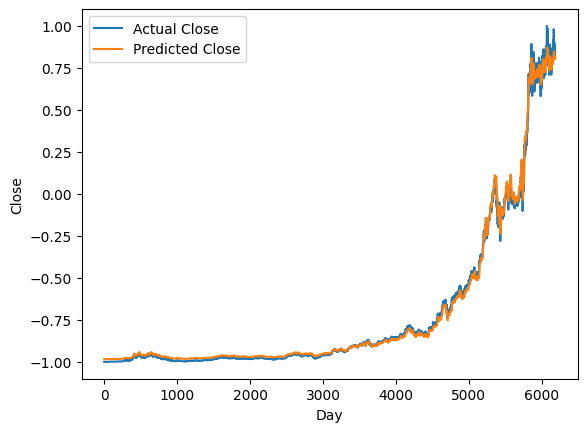

In [ ]:
with torch.no_grad():
  predicted = model(X_train.to(device)).to('cpu').numpy()

plt.plot(y_train, label='Actual Close')
plt.plot(predicted, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show

In [ ]:
predicted

array([[-0.98399246],
       [-0.9839914 ],
       [-0.98399734],
       ...,
       [ 0.80679375],
       [ 0.80248123],
       [ 0.8049271 ]], dtype=float32)

In [ ]:
train_pred = predicted.flatten()

dummies = np.zeros( (X_train.shape[0], look_back+1) )
dummies[:, 0] = train_pred

dummies = scaler.inverse_transform(dummies)

train_pred = dc(dummies[:, 0])
train_pred

array([  1.56353365,   1.5636337 ,   1.56307789, ..., 168.55404568,
       168.15190436, 168.37998194])

In [ ]:
dummies = np.zeros( (X_train.shape[0], look_back+1) )
dummies[:, 0] = y_train.flatten()

dummies = scaler.inverse_transform(dummies)

new_y_train = dc(dummies[:, 0])
new_y_train

array([7.91646265e-02, 7.65634249e-02, 7.52572660e-02, ...,
       1.69091505e+02, 1.73315001e+02, 1.68871003e+02])

<function matplotlib.pyplot.show(close=None, block=None)>

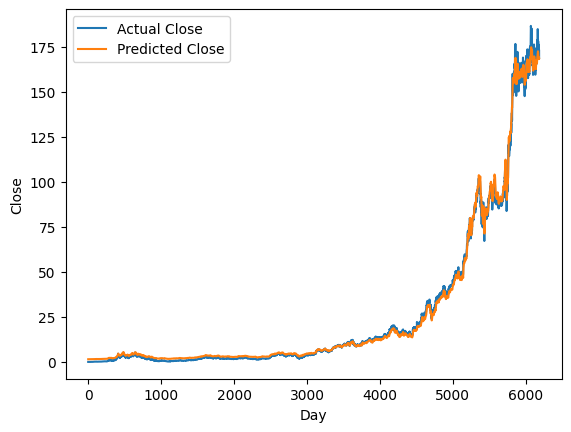

In [ ]:
plt.plot(new_y_train, label='Actual Close')
plt.plot(train_pred, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show

In [ ]:
test_pred = model(X_test.to(device)).detach().cpu().numpy()

dummies = np.zeros( (X_test.shape[0], look_back+1) )
dummies[:, 0] = test_pred.flatten()

dummies = scaler.inverse_transform(dummies)

test_pred = dc(dummies[:, 0])
test_pred

array([167.78368982, 167.465126  , 166.83781955, 166.89087184,
       167.10459834, 167.28865003, 167.10758861, 167.24216745,
       167.10225837, 166.99148498, 166.51114087, 166.66442834,
       166.35321792, 165.6500153 , 164.88033197, 164.1924531 ,
       163.47661687, 163.60439812, 163.56206746, 162.962635  ,
       162.74575704, 162.06020146, 161.06610336, 159.44629955,
       156.21018243, 153.96588458, 151.28983174, 148.8406448 ,
       147.18440194, 146.97638362, 148.24338001, 149.92295588,
       151.0580191 , 149.60961113, 152.50642707, 154.68033128,
       156.83833371, 158.28777549, 158.98028428, 158.499829  ,
       158.86029552, 158.71775189, 158.87541361, 158.24537813,
       157.37081858, 156.28620644, 154.52519851, 154.38485034,
       154.69147532, 154.83449139, 154.61131051, 154.70439796,
       154.02668489, 153.20402154, 150.51287839, 147.90486808,
       146.56927334, 147.3130836 , 147.58218013, 147.17511987,
       148.20230548, 150.51998723, 153.16908873, 155.84

In [ ]:
dummies = np.zeros( (X_test.shape[0], look_back+1) )
dummies[:, 0] = y_test.flatten()

dummies = scaler.inverse_transform(dummies)

new_y_test = dc(dummies[:, 0])
new_y_test

array([170.01749949, 167.07899763, 170.41700626, 171.03700377,
       171.0684961 , 169.66949429, 170.66099675, 169.20100565,
       168.64449858, 166.71699707, 170.40449492, 167.52200227,
       164.35699578, 163.25399737, 162.55400179, 161.48599177,
       165.36199892, 165.20699954, 161.21400501, 162.13799851,
       158.91749416, 156.29899568, 151.66749509, 142.64300408,
       144.54400445, 139.98599336, 138.87249844, 139.63749627,
       143.97799855, 149.57350001, 151.19349835, 150.61250219,
       138.84550541, 157.63949825, 157.93550165, 161.41349717,
       161.18949925, 159.003495  , 153.29350176, 155.1670061 ,
       156.51049894, 158.10049453, 154.6524962 , 152.60149876,
       150.19749381, 144.82699629, 151.35800212, 153.78849709,
       153.56300403, 151.14199678, 152.05250627, 147.89849848,
       145.64100565, 137.45300383, 136.01449488, 139.27900567,
       146.81750468, 145.52450739, 141.8529947 , 147.36650272,
       153.10400311, 157.23899657, 161.25050521, 161.49

<function matplotlib.pyplot.show(close=None, block=None)>

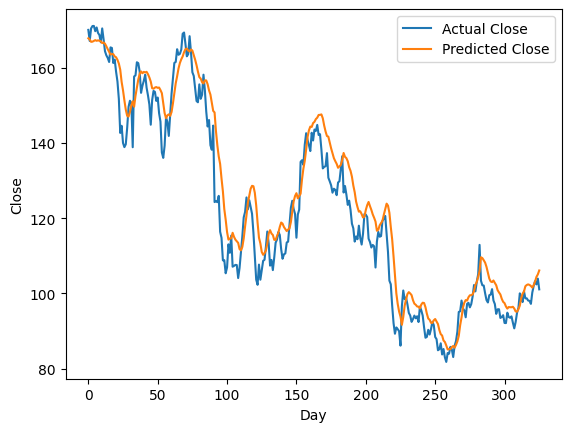

In [ ]:
plt.plot(new_y_test, label='Actual Close')
plt.plot(test_pred, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show



> Seems overfitted :(

